In [10]:
import os
import pickle
import numpy as np
import pandas as pd

# an example pid and eid 
pid = '5544da75-8d34-47cb-9092-1f91e713e79c' # with 23 channels having more than 0.6 auroc for right/left decoding
base_path = '/mnt/data/AdaptiveControl/IBLrawdata/classification/preprocess_firingRate'
path = os.path.join(base_path, f'{pid}.pkl')
with open(path, 'rb') as f:
    data = pickle.load(f)
firing_rates = data['firing_rates'] # shape (n_trials, n_neurons, n_time_bins)
trial_info = data['trial_info'] # dictionary keys ['trial_index', 'labels', 'contrasts', 'distance_to_change', 'prob_left', 'probe_id', 'experiment_id']
depth_info = data['depth_info'] # dictionary keys ['depth', 'ids', 'acronyms', 'ch_indexs', 'x_coordinates', 'y_coordinates', 'z_coordinates']
time_bins = data['time_bins'] # shape (n_time_bins,)
depth = np.array(depth_info['depth'])
ids = np.array(depth_info['ids'])
# Filter conditions
contrast_filter = trial_info['contrasts'] == 1
probability_left_filter = (trial_info['prob_left'] == 0.5) | np.isnan(trial_info['prob_left'])
trial_info_filter = contrast_filter & probability_left_filter
time_filter = time_bins > 0  # time is in milliseconds

# Apply filters
trial_info_filtered_dict = {key: value[trial_info_filter] for key, value in trial_info.items()}
trial_info_filtered = pd.DataFrame(trial_info_filtered_dict)
time_bins_filtered = time_bins[time_filter]
firing_rates_filtered = firing_rates[trial_info_filter, :, :][:, :, time_filter]
labels_filter = trial_info_filtered['labels']

decodability_scores= data['decodability_scores']

index_right = np.where(labels_filter == 1)[0]
index_left = np.where(labels_filter == 0)[0]

firing_rates_right = firing_rates_filtered[index_right, :, :]
firing_rates_left = firing_rates_filtered[index_left, :, :]


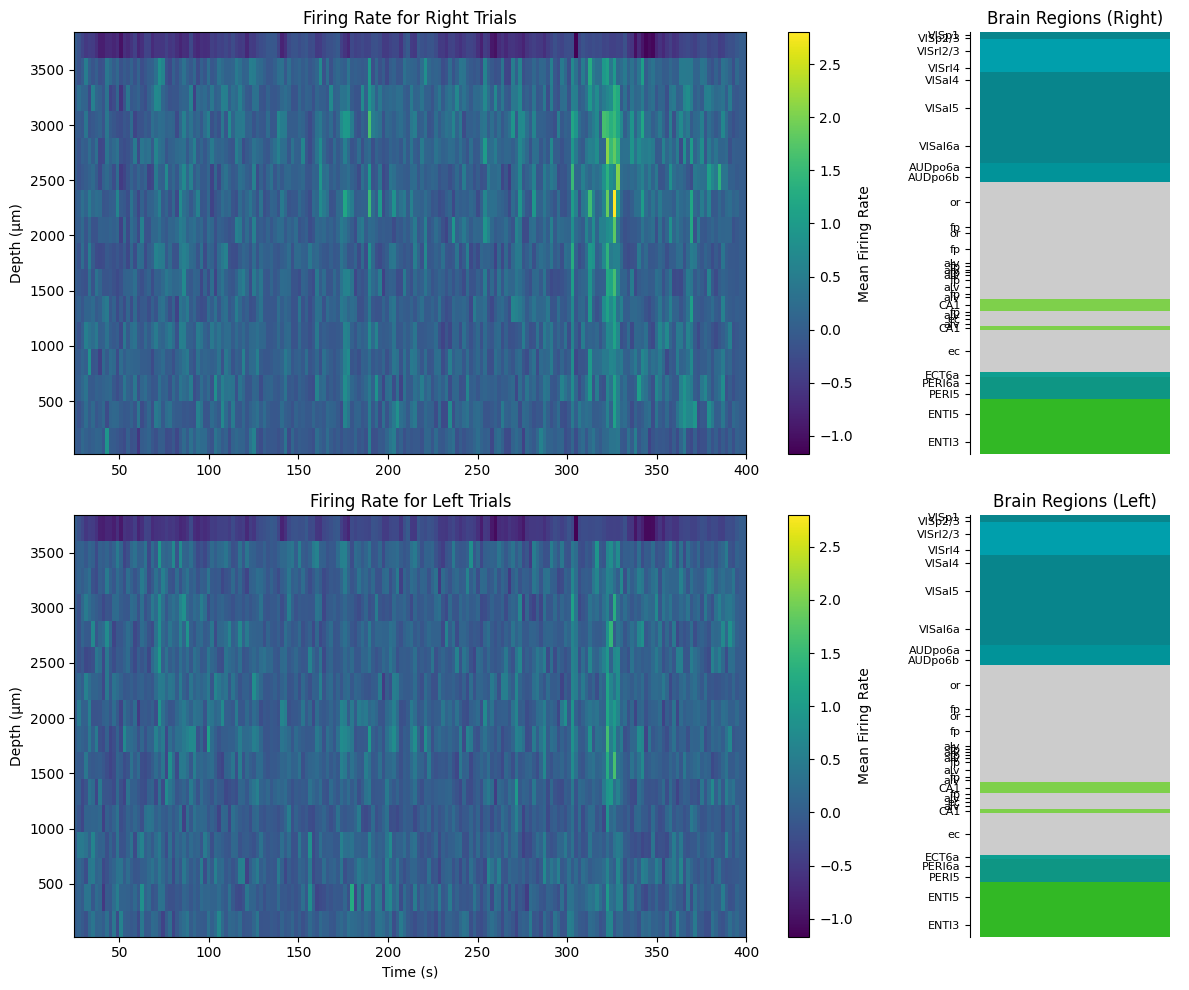

In [11]:
from brainbox.ephys_plots import plot_brain_regions
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Calculate means for right and left trials
firing_rate_right_mean = np.mean(firing_rates_right, axis=0)  # shape: (n_channels, n_time_bins)
firing_rate_left_mean = np.mean(firing_rates_left, axis=0)    # shape: (n_channels, n_time_bins)

# Convert depths to the corresponding shape
depth_order = np.argsort(depth)  # Order depths
firing_rate_right_mean = firing_rate_right_mean[depth_order]
firing_rate_left_mean = firing_rate_left_mean[depth_order]
depth_sorted = depth[depth_order]
ids_sorted = ids[depth_order]

# Calculate global min and max for consistent color scale
global_min = min(np.nanmin(firing_rate_right_mean), np.nanmin(firing_rate_left_mean))
global_max = max(np.nanmax(firing_rate_right_mean), np.nanmax(firing_rate_left_mean))

# Create figure and GridSpec layout
fig = plt.figure(figsize=(12, 10))
gs = GridSpec(2, 2, width_ratios=[4, 1])  # 2 rows, 2 columns

# First column, first row: Right Trials
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(firing_rate_right_mean.T, aspect='auto', origin='lower',
                 extent=[time_bins_filtered[0], time_bins_filtered[-1], depth_sorted[0], depth_sorted[-1]], 
                 cmap='viridis', vmin=global_min, vmax=global_max)
ax1.set_title('Firing Rate for Right Trials')
ax1.set_ylabel('Depth (µm)')
plt.colorbar(im1, ax=ax1, label='Mean Firing Rate')

# Second column, first row: Brain Regions for Right Trials
ax2 = fig.add_subplot(gs[0, 1])
plot_brain_regions(ids_sorted, depth_sorted, display=True, ax=ax2, 
                   title='Brain Regions (Right)', label='Right')

# First column, second row: Left Trials
ax3 = fig.add_subplot(gs[1, 0])
im2 = ax3.imshow(firing_rate_left_mean.T, aspect='auto', origin='lower',
                 extent=[time_bins_filtered[0], time_bins_filtered[-1], depth_sorted[0], depth_sorted[-1]], 
                 cmap='viridis', vmin=global_min, vmax=global_max)
ax3.set_title('Firing Rate for Left Trials')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Depth (µm)')
plt.colorbar(im2, ax=ax3, label='Mean Firing Rate')

# Second column, second row: Brain Regions for Left Trials
ax4 = fig.add_subplot(gs[1, 1])
plot_brain_regions(ids_sorted, depth_sorted, display=True, ax=ax4, 
                   title='Brain Regions (Left)', label='Left')

# Layout adjustment
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


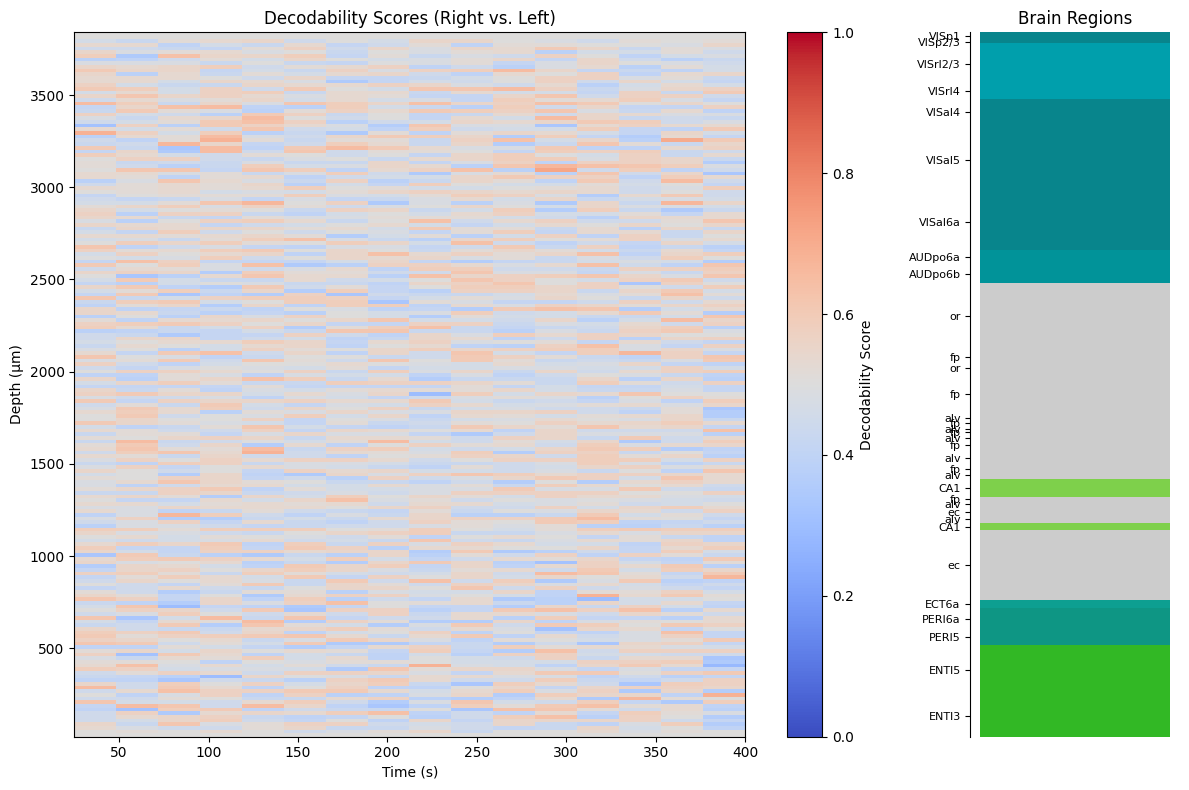

In [12]:
import matplotlib.colors as mcolors

# Reshape and reorder decodability scores by depth
decodability_scores_sorted = decodability_scores[depth_order, :]

# Define the custom colormap and normalization
div_norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1)

# Create figure and GridSpec layout
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(1, 2, width_ratios=[4, 1])  # 1 row, 2 columns

# First column: Decodability Scores
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(decodability_scores_sorted, aspect='auto', origin='lower',
                 extent=[time_bins_filtered[0], time_bins_filtered[-1], depth_sorted[0], depth_sorted[-1]],
                 cmap='coolwarm', norm=div_norm)
ax1.set_title('Decodability Scores (Right vs. Left)')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Depth (µm)')
plt.colorbar(im1, ax=ax1, label='Decodability Score')

# Second column: Brain Regions
ax2 = fig.add_subplot(gs[0, 1])
plot_brain_regions(ids_sorted, depth_sorted, display=True, ax=ax2,
                   title='Brain Regions', label='Decodability')

# Layout adjustment
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


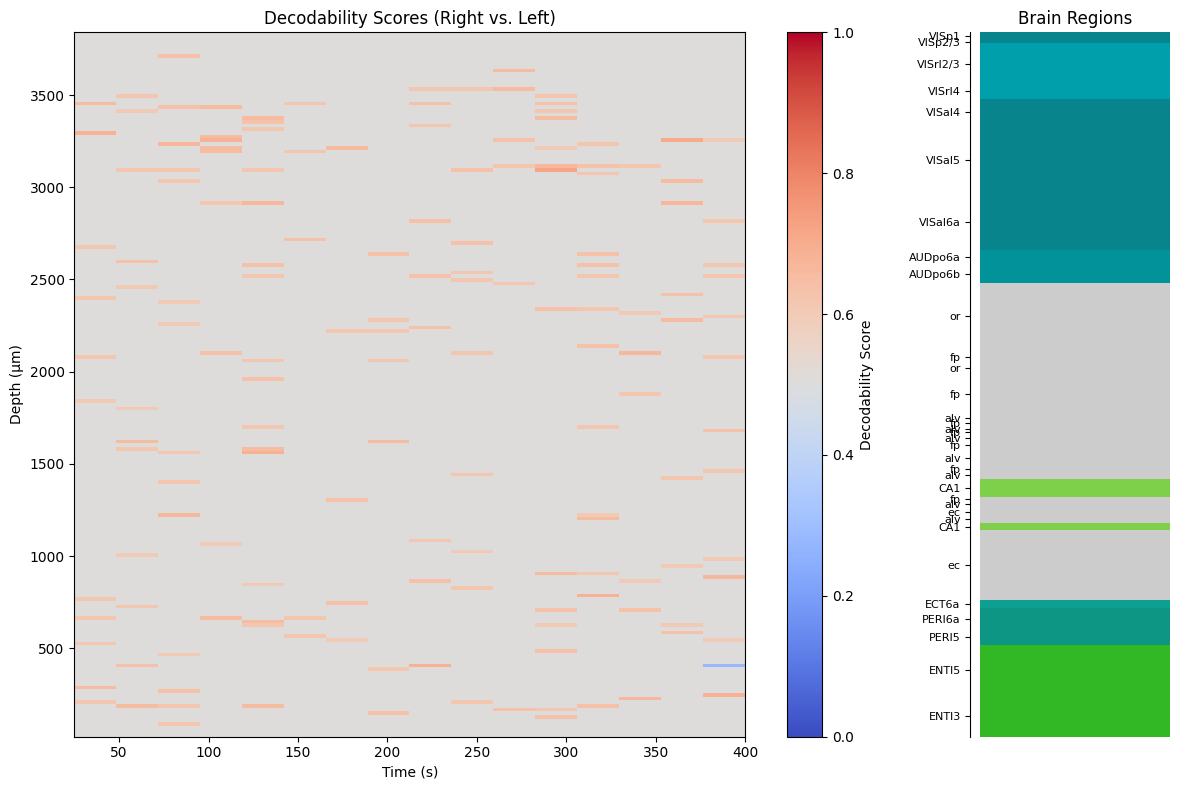

In [13]:
import matplotlib.colors as mcolors

# Preprocess decodability scores: clamp values between 0.3 and 0.6 to 0.5
decodability_scores_processed = decodability_scores.copy()
decodability_scores_processed[(decodability_scores_processed >= 0.3) & (decodability_scores_processed <= 0.6)] = 0.5

# Reshape and reorder decodability scores by depth
decodability_scores_sorted = decodability_scores_processed[depth_order, :]

# Define the custom colormap and normalization
div_norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1)

# Create figure and GridSpec layout
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(1, 2, width_ratios=[4, 1])  # 1 row, 2 columns

# First column: Decodability Scores
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(decodability_scores_sorted, aspect='auto', origin='lower',
                 extent=[time_bins_filtered[0], time_bins_filtered[-1], depth_sorted[0], depth_sorted[-1]],
                 cmap='coolwarm', norm=div_norm)
ax1.set_title('Decodability Scores (Right vs. Left)')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Depth (µm)')
plt.colorbar(im1, ax=ax1, label='Decodability Score')

# Second column: Brain Regions
ax2 = fig.add_subplot(gs[0, 1])
plot_brain_regions(ids_sorted, depth_sorted, display=True, ax=ax2,
                   title='Brain Regions', label='Decodability')

# Layout adjustment
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()
